In [19]:
import h5py
from freeqdsk import geqdsk

In [24]:
with h5py.File('../Testing/beta1.h5','r') as h5f:
    print(h5f.keys())
    FF = h5f['/FluxFunctions']
    print(FF.keys())
    B = h5f['/Boundaries']
    print(B.keys())
    S = h5f['/Scalars']
    print(S.keys())
    #print(FF["PsiX"][()])
    print(FF["Psi_1D"][()])
    print(h5f['Scalars/PsiMagX'][()])
    print(h5f["Scalars/PsiLCFS"][()])
    print(h5f["Scalars/PsiFCFS"][()])
    print(h5f["Scalars/R0"][()])
    print(h5f["Scalars/B0"][()])

<KeysViewHDF5 ['Boundaries', 'FluxFunctions', 'Grid', 'Scalars']>
<KeysViewHDF5 ['B2ave_1D', 'Beta_1D', 'Jave_1D', 'PsiX', 'Psi_1D', 'Shear_1D', 'Vol_1D', 'Well_1D', 'dG2dPsi_1D', 'dVdPsi_1D', 'fpol', 'pprime', 'pres', 'qpsi']>
<KeysViewHDF5 ['FCFS', 'LCFS', 'ilim', 'olim']>
<KeysViewHDF5 ['B0', 'Ip', 'PsiFCFS', 'PsiLCFS', 'PsiMagX', 'R0', 'RMagX', 'Z0', 'ZMagX']>
[0.         0.00195312 0.00390625 0.00585937 0.0078125  0.00976562
 0.01171875 0.01367187 0.015625   0.01757812 0.01953125 0.02148437
 0.0234375  0.02539062 0.02734375 0.02929687 0.03125    0.03320312
 0.03515625 0.03710937 0.0390625  0.04101562 0.04296875 0.04492187
 0.046875   0.04882812 0.05078124 0.05273437 0.05468749 0.05664062
 0.05859374 0.06054687 0.06249999 0.06445312 0.06640624 0.06835937
 0.07031249 0.07226562 0.07421874 0.07617187 0.07812499 0.08007812
 0.08203124 0.08398437 0.08593749 0.08789062 0.08984374 0.09179687
 0.09374999 0.09570312 0.09765624 0.09960937 0.10156249 0.10351561
 0.10546874 0.10742186 0.10937

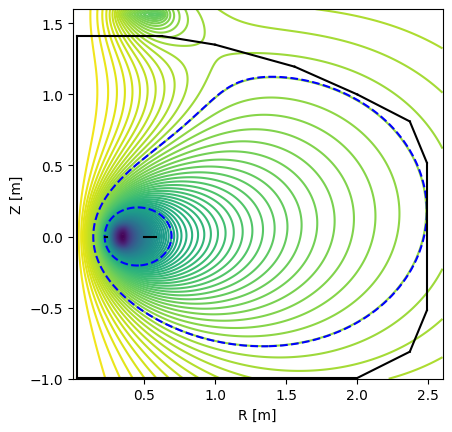

In [13]:
def plot_h5eq(h5eq):
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots()
    ax.contour(h5eq['Grid']['R'],h5eq['Grid']['Z'],h5eq['Grid']['Psi'],100)
    ax.set_xlabel(f'R [{h5eq["Grid"]["R"].attrs["UNITS"].decode()}]')
    ax.set_ylabel(f'Z [{h5eq["Grid"]["Z"].attrs["UNITS"].decode()}]')
    ax.set_aspect('equal')
    ax.plot(h5eq['Boundaries']['LCFS'][:,0],h5eq['Boundaries']['LCFS'][:,1],'b--')
    ax.plot(h5eq["Boundaries"]["FCFS"][:, 0], h5eq["Boundaries"]["FCFS"][:, 1], "b--")
    ilim = h5eq["Boundaries"]["ilim"]
    olim = h5eq["Boundaries"]["lim"]
    for lim in [ilim, olim]:
        for i in range(lim.shape[0]):
            ax.plot(lim[i, :, 0], lim[i, :, 1], "k-")


with h5py.File('../Testing/beta1.h5','r') as h5f:
    plot_h5eq(h5f)

<HDF5 dataset "PsiX": shape (513,), type "<f8">
<HDF5 dataset "pprime": shape (513,), type "<f8">


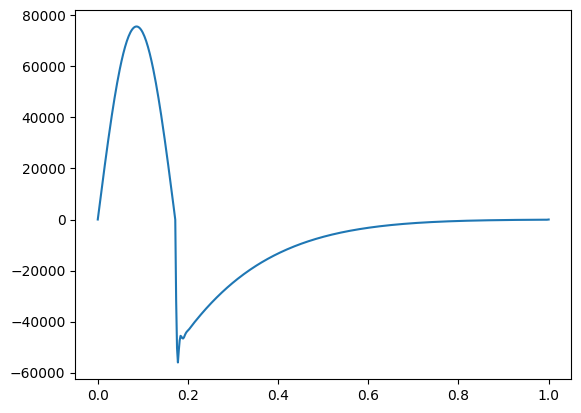

In [18]:
def plot_h5eq_ff(h5eq):
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots()
    plt.plot(h5eq['FluxFunctions']['PsiX'][()],h5eq['FluxFunctions']['pprime'][()],label='pprime')


with h5py.File('../Testing/beta1.h5','r') as h5f:
    print(h5f['FluxFunctions']['PsiX'])
    print(h5f["FluxFunctions"]["pprime"])
    plot_h5eq_ff(h5f)

<HDF5 dataset "PsiX": shape (513,), type "<f8">
<HDF5 dataset "pprime": shape (513,), type "<f8">


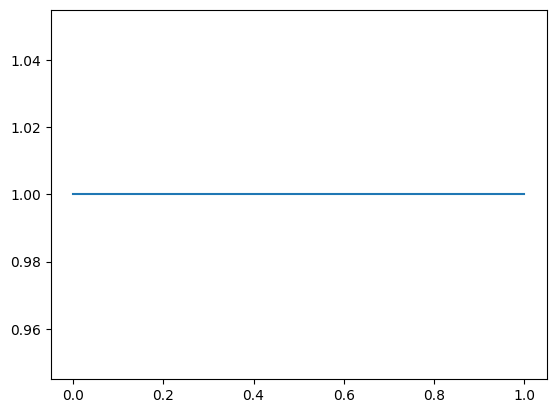

In [30]:
def plot_h5eq_ff(h5eq):
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots()
    plt.plot(h5eq['FluxFunctions']['PsiX'][()],h5eq['FluxFunctions']['G_1D'][()],label='fpol')


with h5py.File('../Testing/beta1.h5','r') as h5f:
    print(h5f['FluxFunctions']['PsiX'])
    print(h5f["FluxFunctions"]["pprime"])
    plot_h5eq_ff(h5f)

In [27]:
from importlib import reload
import dipoleq_h5togeqdsk as dip2g
reload(dip2g)

with h5py.File('../Testing/beta1.h5','r') as h5f:
    gdata, oname = dip2g.dipoleq_to_geqdsk(h5f)
    ofile = f"{oname}.geqdsk"
    with open(ofile, 'w') as fh:
        geqdsk.write(gdata, fh, label=oname)
        print(f"# {oname:s} written to {ofile}")
    

# beta1 written to beta1.geqdsk
